# BinaryNet on CIFAR10

<a href="https://mybinder.org/v2/gh/larq/larq/master?filepath=docs%2Fexamples%2Fbinarynet_cifar10.ipynb"><button data-md-color-primary="larq">Run on Binder</button></a> <a href="https://github.com/larq/larq/blob/master/docs/examples/binarynet_cifar10.ipynb"><button data-md-color-primary="larq">View on GitHub</button></a>

In this example we demonstrate how to use Larq to build and train BinaryNet on the CIFAR10 dataset to achieve a validation accuracy approximately 83% on laptop hardware.
On a Nvidia GTX 1050 Ti Max-Q it takes approximately 200 minutes to train. For simplicity, compared to the original papers [BinaryConnect: Training Deep Neural Networks with binary weights during propagations](https://arxiv.org/abs/1511.00363), and [Binarized Neural Networks: Training Deep Neural Networks with Weights and Activations Constrained to +1 or -1](http://arxiv.org/abs/1602.02830), we do not impliment learning rate scaling, or image whitening.

In [1]:
import tensorflow as tf
import larq as lq
import numpy as np
import matplotlib.pyplot as plt

## Import CIFAR10 Dataset

We download and normalize the CIFAR10 dataset.

In [2]:
num_classes = 10

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

train_images = train_images.reshape((50000, 32, 32, 3)).astype("float32")
test_images = test_images.reshape((10000, 32, 32, 3)).astype("float32")

# Normalize pixel values to be between -1 and 1
train_images, test_images = train_images / 127.5 - 1, test_images / 127.5 - 1

train_labels = tf.keras.utils.to_categorical(train_labels, num_classes)
test_labels = tf.keras.utils.to_categorical(test_labels, num_classes)

## Build BinaryNet

Here we build the BinaryNet model layer by layer using the [Keras Sequential API](https://www.tensorflow.org/guide/keras).

In [4]:
# All quantized layers except the first will use the same options
kwargs = dict(input_quantizer="ste_sign",
              kernel_quantizer="ste_sign",
              kernel_constraint="weight_clip",
              use_bias=False)

model = tf.keras.models.Sequential([
    # In the first layer we only quantize the weights and not the input
    lq.layers.QuantConv2D(128, 3,
                          kernel_quantizer="ste_sign",
                          kernel_constraint="weight_clip",
                          use_bias=False,
                          input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(128, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(256, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantConv2D(512, 3, padding="same", **kwargs),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Flatten(),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(1024, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),

    lq.layers.QuantDense(10, **kwargs),
    tf.keras.layers.BatchNormalization(momentum=0.999, scale=False),
    tf.keras.layers.Activation("softmax")
])

One can output a summary of the model:

In [5]:
lq.models.summary(model)

+sequential_1 stats-------------------------------------------------------------------+
| Layer                   Input prec.            Outputs   # 1-bit  # 32-bit   Memory |
|                               (bit)                                            (kB) |
+-------------------------------------------------------------------------------------+
| quant_conv2d_6                    -  (-1, 30, 30, 128)      3456         0     0.42 |
| batch_normalization_9             -  (-1, 30, 30, 128)         0       384     1.50 |
| quant_conv2d_7                    1  (-1, 30, 30, 128)    147456         0    18.00 |
| max_pooling2d_3                   -  (-1, 15, 15, 128)         0         0     0.00 |
| batch_normalization_10            -  (-1, 15, 15, 128)         0       384     1.50 |
| quant_conv2d_8                    1  (-1, 15, 15, 256)    294912         0    36.00 |
| batch_normalization_11            -  (-1, 15, 15, 256)         0       768     3.00 |
| quant_conv2d_9                

## Model Training

Compile the model and train the model

In [6]:
model.compile(
    tf.keras.optimizers.Adam(lr=0.01,decay=0.0001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [6]:
trained_model = model.fit(
    train_images, 
    train_labels,
    batch_size=50, 
    epochs=100,
    validation_data=(test_images, test_labels),
    shuffle=True
)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 131s 3ms/step - loss: 1.5733 - acc: 0.4533 - val_loss: 1.6368 - val_acc: 0.4244
Epoch 2/100
50000/50000 [==============================] - 125s 3ms/step - loss: 1.1485 - acc: 0.6387 - val_loss: 1.8497 - val_acc: 0.3764
Epoch 3/100
50000/50000 [==============================] - 124s 2ms/step - loss: 0.9641 - acc: 0.7207 - val_loss: 1.5696 - val_acc: 0.4794
Epoch 4/100
50000/50000 [==============================] - 123s 2ms/step - loss: 0.8452 - acc: 0.7728 - val_loss: 1.5765 - val_acc: 0.4669
Epoch 5/100
50000/50000 [==============================] - 123s 2ms/step - loss: 0.7553 - acc: 0.8114 - val_loss: 1.0653 - val_acc: 0.6928
Epoch 6/100
50000/50000 [==============================] - 122s 2ms/step - loss: 0.6841 - acc: 0.8447 - val_loss: 1.0944 - val_acc: 0.6880
Epoch 7/100
50000/50000 [==============================] - 125s 3ms/step - loss: 0.6356 - acc: 0.8685 - val_loss: 0.

## Model Output

We can now plot the final validation accuracy and loss:

0.9956000019311905
0.8320999944210052


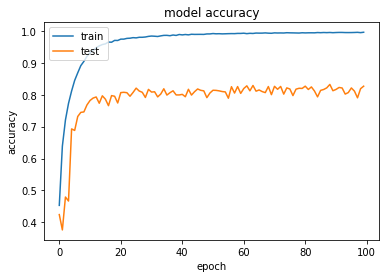

In [ ]:
plt.plot(trained_model.history['acc'])
plt.plot(trained_model.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.max(trained_model.history['acc']))
print(np.max(trained_model.history['val_acc']))

0.3663262344896793
0.7790719392895699


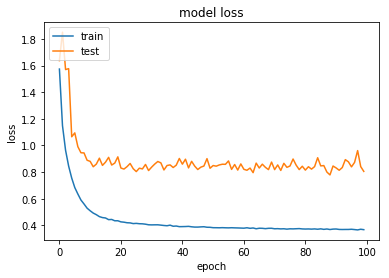

In [ ]:
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

print(np.min(trained_model.history['loss']))
print(np.min(trained_model.history['val_loss']))